In [1]:
%load_ext Cython

In [2]:
%%cython -a
#cython: cdivision = True,profile = True
from cpython cimport array
import array

cimport tictactics_cython
from tictactics_cython cimport Board
import numpy as np
import itertools
import matplotlib
import cProfile
from matplotlib import pyplot as plt

import random
import time
from IPython import display
import weakref
from cpython.exc cimport PyErr_CheckSignals

ctypedef unsigned long long int64
cdef enum:
    MAX_MOVES = 81
    MAX_LENGTH = 81

    
cdef class MC_node(object):
    cdef:
        int64 key
        int is_root
        int leaf,solved,result,player,n_children,sib_index
        long long N[MAX_MOVES],V[MAX_MOVES]
        double Q[MAX_MOVES]
        object actions
        MC_node child
        MC_node sib
        MC_node parent

    
    
    def __init__(self,Board game,int is_root=0):
        self.player = 1 if game.player==0 else -1 #tictactics
        self.is_root = is_root
        self.leaf = 1
        self.n_children = 0
        self.key = game.key
        self.solved = game.over
        self.result = game.result


cpdef select(MC_node node,Board game,list moves,double puct_constant = 1): 
    #point node to the selected leaf and append the list of moves to 'moves'

    cdef int i,best_index
    cdef object move,best_move
    cdef double q,u,max_puct
    cdef double sqrt_sum_children
    cdef MC_node best_child,child
    
    while not node.leaf and not node.solved:
        
        max_puct = -10000. #just a very bad number
        best_move = None
        sum_children = 0
        for i in xrange(node.n_children):
            sqrt_sum_children += node.N[i]
        sqrt_sum_children = sqrt_sum_children**0.5
            
        child = node.child
        for i in xrange(node.n_children):
            move = node.actions[i]
            
            if child.solved:
                q = node.player * child.result
            else:
                q = node.player * node.Q[i]
                    
        
            u = puct_constant * sqrt_sum_children / (1 + node.N[i])
            if q+u > max_puct:
                max_puct = q+u
                best_move = move
                best_index = i
                best_child = child
            child = child.sib #on the last run, this points to unknown location, probably ok
                            
        node = best_child
        game.update_move(best_move)
        moves.append(best_move)
        
        
    return node , best_index
    
    
cdef int evaluate(MC_node node,Board game,list moves):
    #MC rollout, maybe a short PN search
    cdef int result
    cdef object actions,move
    cdef int n_actions,i
    cdef int64 r
    while not game.over:

        actions = game.legal_moves()
        n_actions = len(actions)
        r = rng()
        move = actions[r%n_actions]
        moves.append(move)
        game.update_move(move)

                
    if game.result == 1:
        result = 1
    elif game.result == -1:
        result = -1
    else:
        result = 0
    return result



cdef backprop(MC_node node, Board game, int last_index, int result , int prune = 0):
    #MC backprop
    cdef int index
    cdef MC_node child

    #incoming node should be leaf or solved
    
    while not node.is_root:
        # MC stuff
        index = node.sib_index
        node = node.parent
        
        #check solved
        child = node.child
        node.solved = 1
        for i in xrange(node.n_children):
            if child.result * node.player > node.result * node.player:
                node.result = child.result
            if not child.solved:
                node.solved = 0 #game isn't solved yet
            child = child.sib #the last reference will go somewhere random, but it doesn't matter
        if node.result:
            node.solved = 1 #yes it is
        
        node.N[index]+=1
        node.V[index]+=result   
        node.Q[index]=<double>(node.V[index])/<double>node.N[index]
           
        
        

cdef expand(MC_node node,Board game):
    # Add Children to tree
#     for move in game.legal_moves():
    cdef int i
    cdef MC_node sib
    node.actions = game.legal_moves()
    node.n_children = len(node.actions)

    for i in xrange(node.n_children):
        node.N[i] = 0
        node.V[i] = 0
        node.Q[i] = 0.
        game.update_move(node.actions[i])
        child = MC_node(game)
        child.sib_index = i
        child.parent = node
        
        if i == 0:
            node.child = child
            sib = child
        else:
            sib.sib = child
            sib = child

        game.erase_move()
    if node.n_children == 0:
        node.leaf = 1
    else:
        node.leaf = 0
        
        
cpdef mc_pass(MC_node root,Board game,int branch = -1):
    cdef int last_index
    cdef double puct_constant
    cdef MC_node node
    cdef list moves
    moves = []
    node , last_index = select(root,game,moves,puct_constant = 0.75)
    
    
    if node.is_root or node.parent.N[node.sib_index]>branch:
        expand(node,game)
    result = evaluate(node,game,moves)
    backprop(node,game,last_index,result)
    
    


cpdef mc_sim(MC_node root,Board game,int branch = -1,long passes = 1000000):
    cdef int i,count
    cdef int log_len
    count = 0
    log_len = len(game.log)
    for i in xrange(passes):
        for _ in xrange(len(game.log)-log_len):
            game.erase_move()
        mc_pass(root,game,branch)
        count += 1
        if count%10000==0:
            print_node(root)
            PyErr_CheckSignals()

            
def print_node(MC_node node):
    display.clear_output(wait=True)
    print node.key
    print 'this node has {} children'.format(node.n_children)
    print_data = []
    for i in xrange(node.n_children):
        print_data.append((node.actions[i],node.N[i],node.Q[i],get_principal(node,i)[:66]))
    
    print_data = sorted(print_data,key = lambda x: - x[1])
    
    
    
    for data in print_data:
        print 'move:{:5}, runs:{:9}, eval:{:+1.4f}, principal:{:15}'.format(*data)
    print
    print get_principal(node)

def get_principal(MC_node node,int child = -1):
    cdef object s,dummy
    cdef int best_i,best_N,i
    s = ''
    if child != -1:
        dummy = node.actions[child]
        if type(dummy) == tuple:
            dummy = ''.join(map(str,dummy))
        s += str(dummy) + ' '
        
        node = node.child
        for i in xrange(child):
            node = node.sib
            
        
        
    while not node.leaf:
        best_i = -1
        best_N = -1
        for i in xrange(node.n_children):
            if node.N[i] > best_N:
                best_N = node.N[i]
                best_i = i
        dummy = node.actions[best_i]
        if type(dummy) == tuple:
            dummy = ''.join(map(str,dummy))
        s += str(dummy) + ' '
    
        node = node.child
        for i in xrange(best_i):
            node = node.sib
    return s

cdef int64 seed[2]
seed[1] = 42

cdef int64 rng():
    cdef int64 x,y
    x=seed[0]
    y=seed[1]
    seed[0]=y
    x^=x<<23
    seed[1]=x^y^(x>>17)^(y>>26)
    return seed[1]+y
    

11033996346776159780
this node has 8 children
move:(4, 8), runs:    65362, eval:+0.1904, principal:48 46 52 78 57 64 14 54 83 
move:(5, 8), runs:    10173, eval:+0.1691, principal:58 87 84 73 40 50 
move:(4, 6), runs:     7407, eval:+0.1604, principal:46 50 72 48 47 33 
move:(5, 7), runs:     6454, eval:+0.1557, principal:57 84 73 42 58 76 
move:(5, 6), runs:     5718, eval:+0.1511, principal:56 61 14 55 67 23 
move:(4, 7), runs:     3025, eval:+0.1147, principal:47 55 67 05    
move:(3, 8), runs:     1062, eval:-0.0301, principal:38 08 27 73    
move:(3, 6), runs:      798, eval:-0.1040, principal:36 00 12 48 38 

48 46 52 78 57 64 14 54 83 
         39544690 function calls in 9.542 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
  4320391    1.904    0.000    2.881    0.000 tictactics_cython.pyx:111(update_move)
   100000    1.820    0.000    6.204    0.000 _cython_magic_0a564fd3d79d9ef8822176b1109604ab.pyx:93(evaluate)
 

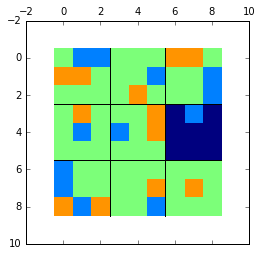

In [4]:
import tictactics_cython as tact
from tictactics_cython import Board
import numpy as np
import itertools
import matplotlib
import cProfile
from matplotlib import pyplot as plt
%matplotlib inline

board = np.zeros((9,9))
for x in [(1,0),(1,1),(0,6),(0,7),(3,5),(4,5),(8,2)]:
    board[x]=1
for o in [(0,1),(0,2),(1,8),(2,8),(4,1),(6,0),(7,0)]:
    board[o]=-1
big_board = np.array([[0,0,0],
                      [0,0,0],
                      [0,0,0]])

player = 1
game = Board(board=board,big_board = big_board,player = player)
for move in [(8,0),(8,1),(7,5),(3,7),(2,4),(8,5),(7,7),(4,3),(3,1),(1,5)]:
    game.update_move(move)
log_len = len(game.log)
player = game.player
root = MC_node(game,1)
tact.fancy_board(game)

cProfile.run('mc_sim(root,game,branch = 50,passes = 100000)',sort = 'tottime')

# print_node(root)


In [ ]:
import tictactics_cython as tact
from tictactics_cython import Board
import numpy as np
import itertools
import matplotlib
import cProfile
from matplotlib import pyplot as plt
%matplotlib inline

board = np.zeros((9,9))
for x in [(1,4),(0,8),(2,6),(5,4),(4,6),(4,8),(6,6),(8,8)]:
    board[x]=1
for o in [(1,0),(2,0),(1,8),(2,8),(3,5),(6,0),(7,7),(7,8)]:
    board[o]=-1
big_board = np.array([[0,0,0],
                      [0,0,0],
                      [0,0,0]])

player = 1
game = Board(board=board,big_board = big_board,player = player)
for move in [(3,4),(2,3),(7,0),(3,2),(0,7)]:
    game.update_move(move)
log_len = len(game.log)

root = MC_node(game,1)
tact.fancy_board(game)

cProfile.run('mc_sim(root,game,branch = 50,passes = 1000000000)',sort = 'tottime')



10884200793324467934
this node has 6 children
move:(1, 3), runs:   976757, eval:-0.0069, principal:13 42 57 83 72 47 53 80 61 15 56 62 16 50 81 75 37 24 73 31 04 03 
move:(2, 4), runs:   158426, eval:-0.0024, principal:24 75 56 71 45 57 84 73 31 03 00 
move:(1, 5), runs:   110441, eval:-0.0079, principal:15 47 53 72 57 83 61 24 75 38 06 01 
move:(0, 4), runs:    32467, eval:+0.0184, principal:04 15 57 83 72 36 01 
move:(0, 3), runs:    19775, eval:+0.0352, principal:03 00 12 56 61 15 57 63 
move:(2, 5), runs:    12133, eval:+0.0622, principal:25 86 61 24 84 74 33 

13 42 57 83 72 47 53 80 61 15 56 62 16 50 81 75 37 24 73 31 04 03 00 


C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:20: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


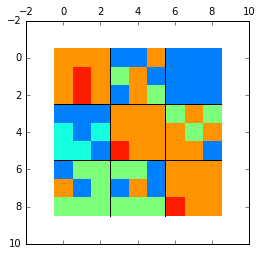

In [18]:
import tictactics_cython as tact
from tictactics_cython import Board
import numpy as np
import itertools
import matplotlib
import cProfile
from matplotlib import pyplot as plt
%matplotlib inline

board = np.zeros((9,9))
for x in [(1,4),(0,8),(2,6),(5,4),(4,6),(4,8),(6,6),(8,8)]:
    board[x]=1
for o in [(1,0),(2,0),(1,8),(2,8),(3,5),(6,0),(7,7),(7,8)]:
    board[o]=-1
big_board = np.array([[0,0,0],
                      [0,0,0],
                      [0,0,0]])

player = 1
game = Board(board=board,big_board = big_board,player = player)
for move in [(3,4),(2,3),(7,0),(3,2),(0,7)]:
    game.update_move(move)
log_len = len(game.log)

root = MC_node(game,1)

seed = [0L,42L]
def rng():
    x=seed[0]
    y=seed[1]
    seed[0]=y
    x^=x<<23
    seed[1]=x^y^(x>>17)^(y>>26)
    return seed[1]+y

while not game.over:

    actions = game.legal_moves()
    n_actions = len(actions)
    r = rng()
    game.update_move(actions[r%n_actions])
    
    
tact.fancy_board(game)
    

In [2]:
%load_ext Cython

In [142]:
%%cython -a
#cython: cdivision = True,profile = True
from cpython cimport array
import array

cimport tictactics_cython
from tictactics_cython cimport Board
import numpy as np
import itertools
import matplotlib
import cProfile
from matplotlib import pyplot as plt

import random
import time
from IPython import display
import weakref
from cpython.exc cimport PyErr_CheckSignals

ctypedef unsigned long long int64
cdef enum:
    MAX_MOVES = 81
    MAX_LENGTH = 81

cdef int64 MASK01,MASK10,MASK11
MASK01 = 0x151515 #a board full of 01
MASK10 = 0x2a2a2a #a board full of 10
MASK11 = 0x3f3f3f #a board full of 11

cpdef object tictactics_simulation_policy(Board game):
    cdef:
        list actions
        int cmove[2]
        int scores[MAX_MOVES]
        int bscores[9],bigbscores[9],bigbtranscore[9]
        int n_acitons,board_index,pos_index,active_board_loc,mp
        int total_score
        long r
        int i,j
        int64 board,bigbtran
    actions = game.legal_moves()
    n_actions = len(actions) #maybe not needed
    
    #first, lets get the importance of the big_board
    total_score = 0
    
    active_board_loc = game.active_board[0]*3+  game.active_board[1]
    mp = game.moves[active_board_loc]
    if mp == 0:
        for i in xrange(n_actions):
            scores[i] = 1
    elif mp<9:
        move = actions[0]
        cmove = move
        
        if game.big_board >> ((cmove[0]/3)*8 + (cmove[1]/3)*2) & 3:
            for i in xrange(n_actions):
                scores[i] = 0
        else:
            board_index = (cmove[0]/3)*3+(cmove[1]/3)
            board = game.board[board_index]

            if game.player == 1:
                #swap board
                board = ((board&MASK01) << 1) | ((board&MASK10)>>1)
            board_score(board,bscores)

            for i in xrange(n_actions):
                move = actions[i]
                cmove = move
                scores[i] = bscores[(cmove[0]%3)*3 + (cmove[1]%3)]
    else:
        for i in xrange(n_actions):
            move = actions[i]
            cmove = move
            if game.big_board >> ((cmove[0]/3)*8 + (cmove[1]/3)*2) & 3:
                for i in xrange(n_actions):
                    scores[i] = 0
            else:
                board_index = (cmove[0]/3)*3+(cmove[1]/3)
                board = game.board[board_index]

                if game.player == 1:
                    #swap board
                    board = ((board&MASK01) << 1) | ((board&MASK10)>>1)
                board_score(board,bscores) #calculating board_score several times can be improved
                scores[i] = bscores[(cmove[0]%3)*3 + (cmove[1]%3)]
    board = game.big_board
    if game.player == 1:
        board = ((board&MASK01) << 1) | ((board&MASK10)>>1)
    board_score(board,bigbscores)
    board = ((board&MASK01) << 1) | ((board&MASK10)>>1)
    board_score(board,bigbtranscore)
    
    for i in xrange(9):
        if game.moves[i]==9:
            bigbtranscore[i] = 10
    
#     print 'scores'
#     for i in xrange(n_actions):
#         print scores[i]
#     print 'bigbscores'
#     for i in xrange(9):
#         print bigbscores[i]
#     print 'bigbtranscore'
#     for i in xrange(9):
#         print bigbtranscore[i]  
    
    total_score = 0
    for i in xrange(n_actions):
        move = actions[i]
        cmove = move
        board_index = (cmove[0]/3)*3+(cmove[1]/3)
        pos_index =   (cmove[0]%3)*3+(cmove[1]%3)
        scores[i] *= bigbscores[board_index]
        if scores[i] == 64:
            return actions[i]#win!!!
        scores[i] -= bigbtranscore[pos_index]*bigbtranscore[pos_index]
        scores[i] += 10 #initial relative chance of being chosen
        if scores[i] <0:
            scores[i] = 0
    
        total_score += scores[i]
        
    if total_score == 0:
        for i in xrange(n_actions):
            scores[i] = 1
            total_score+=1
            
    r = (rng()%total_score) + 1
#     print r,total_score
    for i in xrange(n_actions):
        r -= scores[i]
        if r <= 0:
            j=i
            break
            
#     for i in xrange(n_actions):
#         print actions[i] , scores[i]
    return actions[j]
        

                

            

    
cdef board_score(int64 board,int* scores):
    '''
    gives points based on the threats of the board, assumed the board isn't over
    _xx = 8 pts for _
    _oo = 4 pts for _
    __x = 3 pts for _
    __o = 2 pts for _
    ___ = 1 pt  for _
    ox? = 0pt  for any combination of o and x
    
    '''
    
    cdef:
        int64 mut_board,dummy
        int64 x,o,_
        int i,j
        int win = 8
        int block = 4
        int extend = 3
        int prevent = 2
        int start = 1
    for i in xrange(9):
        scores[i] = 0
    
    x = board&MASK01 #includes wild
    o = board&MASK10 #includes wild
    _ = MASK01&(~x)&(~o>>1) #fills 01 place with correct result
    _ |= _<<1 #dilates the result to the 10 place
    #___
    mut_board = 0
    dummy = _ & _ <<  2 & _ <<  4 #horizontal ___
    mut_board |= dummy | dummy >>  2 | dummy >>  4 
    dummy = _ & _ <<  6 & _ << 12 #diagonal / ___
    mut_board |= dummy | dummy >>  6 | dummy >> 12
    dummy = _ & _ <<  8 & _ << 16 #vertical   ___
    mut_board |= dummy | dummy >>  8 | dummy >> 16
    dummy = _ & _ << 10 & _ << 20 #diagonal \ ___
    mut_board |= dummy | dummy >> 10 | dummy >> 20
        
    for i in xrange(3):
        for j in xrange(3):
            if mut_board&3:
                scores[3*i+j] = start
            mut_board >>= 2
        mut_board >>= 2
        
    #__o
    mut_board = ((_ & _ <<  2 & o <<  4)       |  #horizontal __o
                 (o & _ <<  2 & _ <<  4) >> 2  |  #horizontal o__ shifted back 2 (to populate the blank spot)
                 (_ & o <<  2 & _ <<  4) >> 4  |  #horizontal _o_ shifted back 4
                 (_ & _ <<  6 & o << 12)       |  #diagonal / __o
                 (o & _ <<  6 & _ << 12) >> 6  |  #diagonal / o__ shifted back 6
                 (_ & o <<  6 & _ << 12) >> 12 |  #diagonal / _o_ shifted back 12
                 (_ & _ <<  8 & o << 16)       |  #vertical   __o
                 (o & _ <<  8 & _ << 16) >> 8  |  #vertical   o__ shifted back 8
                 (_ & o <<  8 & _ << 16) >> 16 |  #vertical   _o_ shifted back 16
                 (_ & _ << 10 & o << 20)       |  #diagonal \ __o
                 (o & _ << 10 & _ << 20) >> 10 |  #diagonal \ o__ shifted back 10
                 (_ & o << 10 & _ << 20) >> 20)   #diagonal \ _o_ shifted back 20
    
    #_o_ #need to count twice since there are two open spots
    
    mut_board|= ((_ & o <<  2 & _ <<  4)       |  #horizontal _o_
                 (_ & _ <<  2 & o <<  4) >> 2  |  #horizontal __o shifted back 2 (to populate the blank spot)
                 (o & _ <<  2 & _ <<  4) >> 4  |  #horizontal o__ shifted back 4
                 (_ & o <<  6 & _ << 12)       |  #diagonal / _o_
                 (_ & _ <<  6 & o << 12) >> 6  |  #diagonal / __o shifted back 6
                 (o & _ <<  6 & _ << 12) >> 12 |  #diagonal / o__ shifted back 12
                 (_ & o <<  8 & _ << 16)       |  #vertical   _o_
                 (_ & _ <<  8 & o << 16) >> 8  |  #vertical   __o shifted back 8
                 (o & _ <<  8 & _ << 16) >> 16 |  #vertical   o__ shifted back 16
                 (_ & o << 10 & _ << 20)       |  #diagonal \ _o_
                 (_ & _ << 10 & o << 20) >> 10 |  #diagonal \ __o shifted back 10
                 (o & _ << 10 & _ << 20) >> 20)   #diagonal \ o__ shifted back 20
    for i in xrange(3):
        for j in xrange(3):
            if mut_board&3:
                scores[3*i+j] = prevent
            mut_board >>= 2
        mut_board >>= 2

    #__x
    mut_board = ((_ & _ <<  2 & x <<  4)       |  #horizontal __x
                 (x & _ <<  2 & _ <<  4) >> 2  |  #horizontal x__ shifted back 2 (to populate the blank spot)
                 (_ & x <<  2 & _ <<  4) >> 4  |  #horizontal _x_ shifted back 4
                 (_ & _ <<  6 & x << 12)       |  #diagonal / __x
                 (x & _ <<  6 & _ << 12) >> 6  |  #diagonal / x__ shifted back 6
                 (_ & x <<  6 & _ << 12) >> 12 |  #diagonal / _x_ shifted back 12
                 (_ & _ <<  8 & x << 16)       |  #vertical   __x
                 (x & _ <<  8 & _ << 16) >> 8  |  #vertical   x__ shifted back 8
                 (_ & x <<  8 & _ << 16) >> 16 |  #vertical   _x_ shifted back 16
                 (_ & _ << 10 & x << 20)       |  #diagonal \ __x
                 (x & _ << 10 & _ << 20) >> 10 |  #diagonal \ x__ shifted back 10
                 (_ & x << 10 & _ << 20) >> 20)   #diagonal \ _x_ shifted back 20
    
    #_x_ #need to count twice since there are two open spots
    
    mut_board|= ((_ & x <<  2 & _ <<  4)       |  #horizontal _x_
                 (_ & _ <<  2 & x <<  4) >> 2  |  #horizontal __x shifted back 2 (to populate the blank spot)
                 (x & _ <<  2 & _ <<  4) >> 4  |  #horizontal x__ shifted back 4
                 (_ & x <<  6 & _ << 12)       |  #diagonal / _x_
                 (_ & _ <<  6 & x << 12) >> 6  |  #diagonal / __x shifted back 6
                 (x & _ <<  6 & _ << 12) >> 12 |  #diagonal / x__ shifted back 12
                 (_ & x <<  8 & _ << 16)       |  #vertical   _x_
                 (_ & _ <<  8 & x << 16) >> 8  |  #vertical   __x shifted back 8
                 (x & _ <<  8 & _ << 16) >> 16 |  #vertical   x__ shifted back 16
                 (_ & x << 10 & _ << 20)       |  #diagonal \ _x_
                 (_ & _ << 10 & x << 20) >> 10 |  #diagonal \ __x shifted back 10
                 (x & _ << 10 & _ << 20) >> 20)   #diagonal \ x__ shifted back 20
    for i in xrange(3):
        for j in xrange(3):
            if mut_board&3:
                scores[3*i+j] = extend
            mut_board >>= 2
        mut_board >>= 2

 
    #_oo
    mut_board = ((_ & o <<  2 & o <<  4)       |  #horizontal _oo
                 (o & _ <<  2 & o <<  4) >> 2  |  #horizontal o_o shifted back 2 (to populate the blank spot)
                 (o & o <<  2 & _ <<  4) >> 4  |  #horizontal oo_ shifted back 4
                 (_ & o <<  6 & o << 12)       |  #diagonal / _oo
                 (o & _ <<  6 & o << 12) >> 6  |  #diagonal / o_o shifted back 6
                 (o & o <<  6 & _ << 12) >> 12 |  #diagonal / oo_ shifted back 12
                 (_ & o <<  8 & o << 16)       |  #vertical   _oo
                 (o & _ <<  8 & o << 16) >> 8  |  #vertical   o_o shifted back 8
                 (o & o <<  8 & _ << 16) >> 16 |  #vertical   oo_ shifted back 16
                 (_ & o << 10 & o << 20)       |  #diagonal \ _oo
                 (o & _ << 10 & o << 20) >> 10 |  #diagonal \ o_o shifted back 10
                 (o & o << 10 & _ << 20) >> 20)   #diagonal \ oo_ shifted back 20
    for i in xrange(3):
        for j in xrange(3):
            if mut_board&3:
                scores[3*i+j] = block
            mut_board >>= 2
        mut_board >>= 2
        
        
    #_xx
    mut_board = ((_ & x <<  2 & x <<  4)       |  #horizontal _xx
                 (x & _ <<  2 & x <<  4) >> 2  |  #horizontal x_x shifted back 2 (to populate the blank spot)
                 (x & x <<  2 & _ <<  4) >> 4  |  #horizontal xx_ shifted back 4
                 (_ & x <<  6 & x << 12)       |  #diagonal / _xx
                 (x & _ <<  6 & x << 12) >> 6  |  #diagonal / x_x shifted back 6
                 (x & x <<  6 & _ << 12) >> 12 |  #diagonal / xx_ shifted back 12
                 (_ & x <<  8 & x << 16)       |  #vertical   _xx
                 (x & _ <<  8 & x << 16) >> 8  |  #vertical   x_x shifted back 8
                 (x & x <<  8 & _ << 16) >> 16 |  #vertical   xx_ shifted back 16
                 (_ & x << 10 & x << 20)       |  #diagonal \ _xx
                 (x & _ << 10 & x << 20) >> 10 |  #diagonal \ x_x shifted back 10
                 (x & x << 10 & _ << 20) >> 20)   #diagonal \ xx_ shifted back 20
    for i in xrange(3):
        for j in xrange(3):
            if mut_board&3:
                scores[3*i+j] = win
            mut_board >>= 2
        mut_board >>= 2
        
    
cdef int64 seed[2]     
seed[1] = 42

cdef int64 rng():
    cdef int64 x,y
    x=seed[0]
    y=seed[1]
    seed[0]=y
    x^=x<<23
    seed[1]=x^y^(x>>17)^(y>>26)
    return seed[1]+y
        
        
cdef int64 test_board
test_board = ((0L<< 0) + (0L<< 2) + (0L<<4) + 
              (0L<< 8) + (0L<<10) + (0L<<12) + 
              (0L<<16) + (0L<<18) + (0L<<20)) 

# test_board = 262178L
# test_board = ((test_board&MASK01) << 1) | ((test_board&MASK10)>>1)
# test_board = 0
cdef int score[9]
board_score(test_board,score)
for i in xrange(9):
    print i/3,',',i%3,'-',score[i]

0 , 0 - 1
0 , 1 - 1
0 , 2 - 1
1 , 0 - 1
1 , 1 - 1
1 , 2 - 1
2 , 0 - 1
2 , 1 - 1
2 , 2 - 1


C:\Users\Todd\Anaconda2\lib\site-packages\ipykernel\__main__.py:24: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


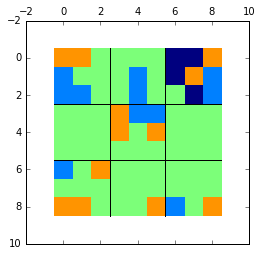

In [133]:
import sys
sys.path.append('../')

import tictactics_cython as tact
from tictactics_cython import Board
import dfpn
import matplotlib
import numpy as np
import cProfile
from matplotlib import pyplot as plt
import time
%matplotlib inline

board = np.zeros((9,9))
for x in [(0,0),(0,1),(0,8),(1,7),(4,3),(4,5),(8,0),(8,1),(8,8)]:
    board[x]=1
for o in [(1,0),(2,0),(1,4),(2,4),(1,8),(2,8),(3,4),(3,5),(6,0)]:
    board[o]=-1
big_board = np.array([[0,0,0],
                      [0,0,0],
                      [0,0,0]])

player = 1
game = Board(board=board,big_board = big_board,player = player)
for move in [(3,3),(2,1),(8,5),(8,6),(6,2)]:
    game.update_move(move)
log_len = len(game.log)
tact.fancy_board(game)

In [170]:
def run(sims = 10000):
    score = 0
    t0 = time.clock()
    for i in xrange(sims):
        for _ in xrange(len(game.log) - log_len):
            game.erase_move()

        while not game.over:

            if game.player == 0:
                move = tictactics_simulation_policy(game)
#                 actions = game.legal_moves()
#                 move = actions[rng()%len(actions)]
                game.update_move(move)
            elif game.player == 1:
                move = tictactics_simulation_policy(game)
#                 actions = game.legal_moves()
#                 move = actions[rng()%len(actions)]
                game.update_move(move)

        score += game.result
    print 'time: {}, score: {}'.format(time.clock() - t0,score)
    
   

In [171]:
run()

time: 2.50725434843, score: 1592


In [98]:
game.big_board

262178L